<a href="https://colab.research.google.com/github/azmiak/Kuliah-Deep-Learning/blob/main/Week%207%20/%20Tugas%20/%20TensorFlow_BiRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Functions

In [1]:
!pip install tensorflow keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from keras_tuner import Hyperband
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
import os
import json
import re

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Device
tf.keras.mixed_precision.set_global_policy('mixed_float16')
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Set seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Parameters
BATCH_SIZE = 64
EPOCHS = 10
EPOCHS_TUNER = 4
validation_split = 0.2
MAX_FEATURES = 15000
MAX_LENGTH = 200

# Preprocessing
def preprocess_text_data(texts, labels, max_features, max_length):
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    x = pad_sequences(sequences, maxlen=max_length)
    y = np.array(labels)
    return x, y, tokenizer

In [4]:
# Build model
def build_model(hp, max_features, max_length):

    model = Sequential()
    model.add(Embedding(
        input_dim=max_features,
        output_dim=hp.Int('embedding_dim', 8, 256, step=64)
    ))

    BiRNN_units = hp.Int('BiRNN_units', 4, 128, step=64)
    model.add(Bidirectional(LSTM(
        units=BiRNN_units,
        activation='tanh',
        recurrent_activation='sigmoid',
        use_bias=True,
        kernel_initializer='glorot_uniform',
        recurrent_initializer='orthogonal',
        bias_initializer='zeros',
        unit_forget_bias=True,
        kernel_regularizer=regularizers.l2(0.001),
        recurrent_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        recurrent_constraint=None,
        bias_constraint=None,
        dropout=0.0,
        recurrent_dropout=0.0,
        seed=None,
        return_sequences=False,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        use_cudnn='auto'
    )))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(Dropout(hp.Float('BiRNN_dropout', 0.3, 0.5, step=0.1)))
    model.add(Dense(BiRNN_units * 2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='zeros'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [5]:
# Evaluation and visualization
def evaluate_and_visualize(model, x_train, y_train, x_test, y_test, dataset_name):
    history = model.fit(
        x_train, y_train,
        validation_split=validation_split,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(x_test, y_test)
    )

    y_prob = model.predict(x_test).flatten()
    y_pred = (y_prob >= 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f1_sq = f1_score(y_test, y_pred)**2
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    print(f"\nFinal Evaluation on {dataset_name} Test Set:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"F1 Squared: {f1_sq:.4f}")
    print(f"AUC      : {auc:.4f}")

    # ROC Curve
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='blue')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # Accuracy graph
    plt.figure()
    plt.plot(history.history['accuracy'], label="Train Accuracy", color='blue', marker='.')
    plt.plot(history.history['val_accuracy'], label="Val Accuracy", color='red', marker='.')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    # Loss graph
    plt.figure()
    plt.plot(history.history['loss'], label="Train Loss", color='blue', marker='.')
    plt.plot(history.history['val_loss'], label="Val Loss", color='red', marker='.')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f1_sq': f1_sq,
        'auc': auc,
        'history': history.history
    }

    # Save to global results
    return {
        "Dataset": dataset_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "F1 Squared": f1_sq,
        "AUC": auc
    }

#IMDB

In [6]:
# Dataset
def IMDB_dataset():
    from tensorflow.keras.datasets import imdb

    # Load the IMDb dataset
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)

    # Pad the sequences to the same length
    x_train = pad_sequences(x_train, maxlen=MAX_LENGTH)
    x_test = pad_sequences(x_test, maxlen=MAX_LENGTH)

    return x_train, y_train, x_test, y_test

Trial 10 Complete [00h 00m 36s]
val_accuracy: 0.829200029373169

Best val_accuracy So Far: 0.8672000169754028
Total elapsed time: 00h 04m 32s

Best Hyperparameters:
embedding_dim: 136
BiRNN_units: 68
BiRNN_dropout: 0.3
learning_rate: 0.0006692581046953691
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.6686 - loss: 0.9295 - val_accuracy: 0.8565 - val_loss: 0.5084
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8975 - loss: 0.4246 - val_accuracy: 0.8623 - val_loss: 0.4677
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9381 - loss: 0.2852 - val_accuracy: 0.7862 - val_loss: 0.6405
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.9408 - loss: 0.2443 - val_accuracy: 0.8386 - val_loss: 0.4672
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.9473 - loss: 0.2053 - val_accuracy: 0.8464 - val_loss: 0.5531
Epoch 6/10
391/391 ━━━━

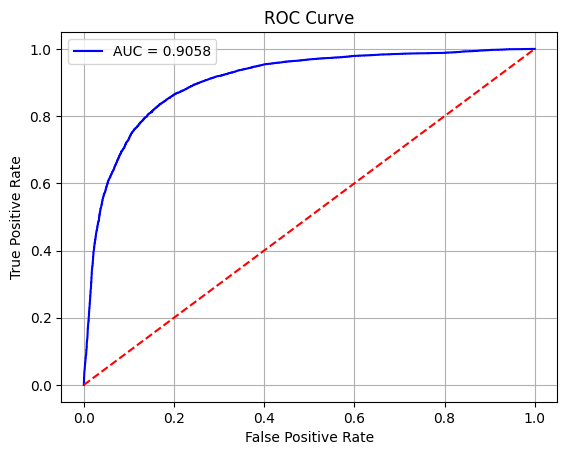

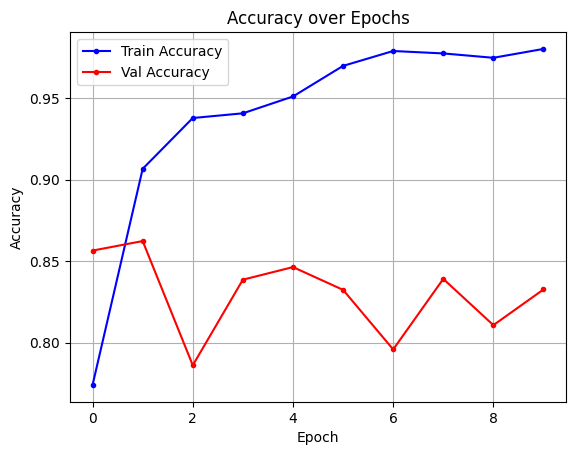

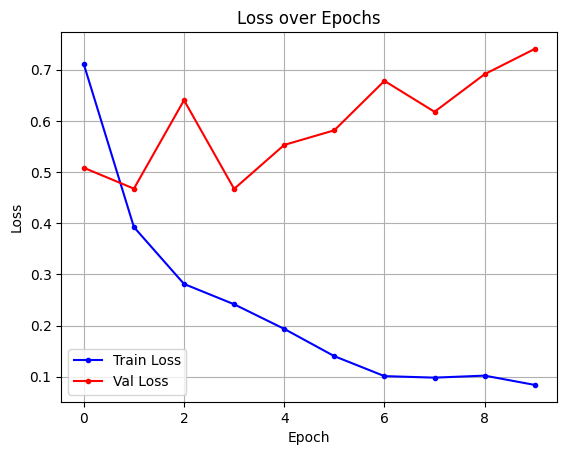

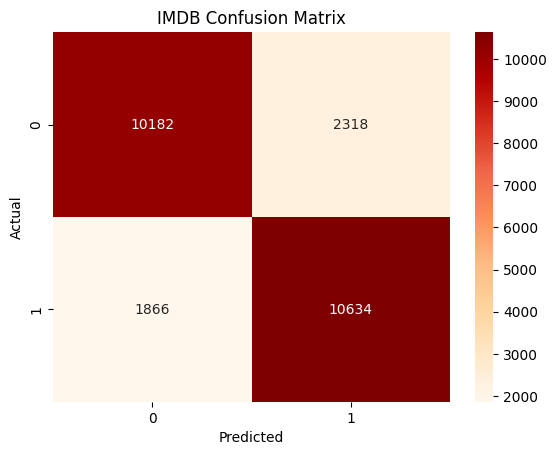

In [7]:
# Execution
def run(dataset_name, prepare_data_fn, max_features, max_length):
    x_train, y_train, x_test, y_test = prepare_data_fn()

    tuner = Hyperband(
        lambda hp: build_model(hp, max_features, max_length),
        objective='val_accuracy',
        max_epochs=EPOCHS_TUNER,
        factor=3,
        directory=None,
        project_name=dataset_name
    )

    tuner.search(x_train, y_train,
                 epochs=EPOCHS_TUNER,
                 batch_size=BATCH_SIZE,
                 validation_split=validation_split)

    best_hps = tuner.get_best_hyperparameters(1)[0]
    print("\nBest Hyperparameters:")
    for k, v in best_hps.values.items():
        print(f"{k}: {v}")

    model = tuner.hypermodel.build(best_hps)
    results = evaluate_and_visualize(model, x_train, y_train, x_test, y_test, dataset_name)

    return model, results

# Running
model, results = run("IMDB", IMDB_dataset, MAX_FEATURES, MAX_LENGTH)

#Review Toko Baju

In [17]:
# Dataset
def ReviewTokoBaju_dataset():
    file_path = "ReviewTokoBaju.csv"
    df = pd.read_csv(file_path)

    df = df.drop_duplicates()
    df = df[['Review Text', 'Recommended IND']].dropna()
    df['label'] = df['Recommended IND'].astype(int)

    texts = df['Review Text'].astype(str).tolist()
    labels = df['label'].tolist()

    x, y, tokenizer = preprocess_text_data(texts, labels, MAX_FEATURES, MAX_LENGTH)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

    return x_train, y_train, x_test, y_test

Trial 10 Complete [00h 00m 29s]
val_accuracy: 0.865028977394104

Best val_accuracy So Far: 0.8766216039657593
Total elapsed time: 00h 03m 49s

Best Hyperparameters:
embedding_dim: 136
BiRNN_units: 68
BiRNN_dropout: 0.4
learning_rate: 0.0002356760971962608
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Epoch 1/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8074 - loss: 0.9166 - val_accuracy: 0.8755 - val_loss: 0.5507
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8907 - loss: 0.4983 - val_accuracy: 0.8545 - val_loss: 0.5217
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9152 - loss: 0.3948 - val_accuracy: 0.8865 - val_loss: 0.4611
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9344 - loss: 0.3243 - val_accuracy: 0.8757 - val_loss: 0.4805
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9480 - loss: 0.2781 - val_accuracy: 0.8790 - val_loss: 0.5335
Epoch 6/10
283/283 ━━━━━━━

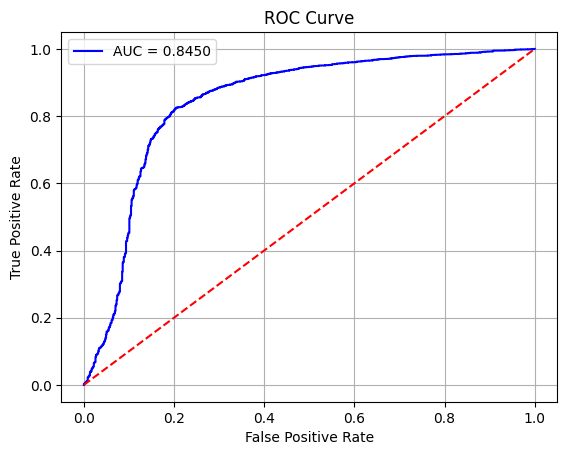

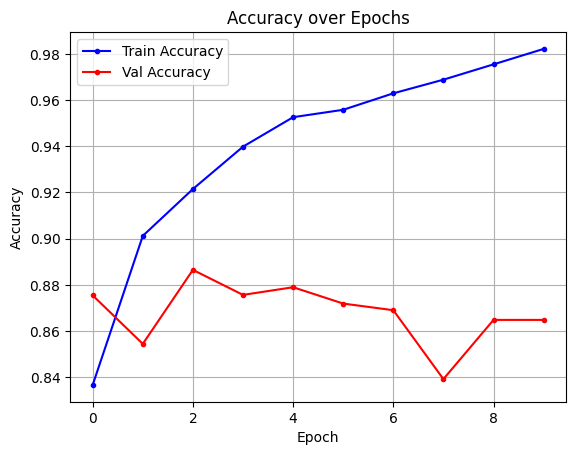

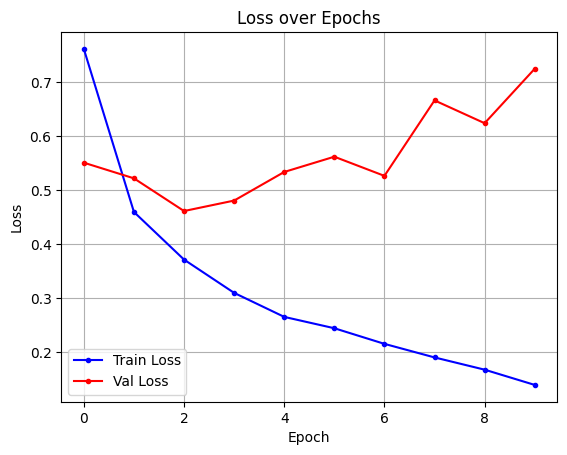

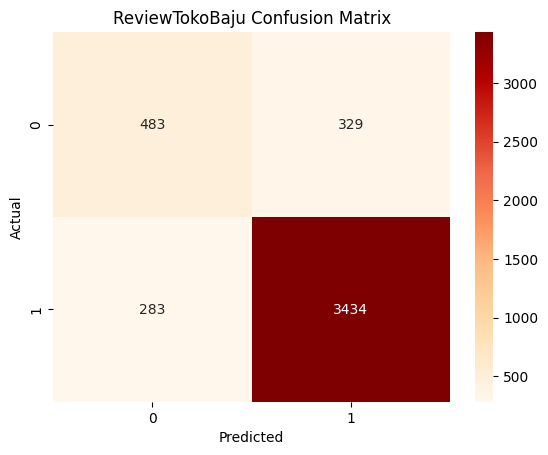

In [21]:
# Execution
def run(dataset_name, prepare_data_fn, max_features, max_length):
    x_train, y_train, x_test, y_test = prepare_data_fn()

    tuner = Hyperband(
        lambda hp: build_model(hp, max_features, max_length),
        objective='val_accuracy',
        max_epochs=EPOCHS_TUNER,
        factor=3,
        directory=f'tuner_{dataset_name}',
        project_name=dataset_name
    )

    tuner.search(x_train, y_train,
                 epochs=EPOCHS_TUNER,
                 batch_size=BATCH_SIZE,
                 validation_split=validation_split)

    best_hps = tuner.get_best_hyperparameters(1)[0]
    print("\nBest Hyperparameters:")
    for k, v in best_hps.values.items():
        print(f"{k}: {v}")

    model = tuner.hypermodel.build(best_hps)
    results = evaluate_and_visualize(model, x_train, y_train, x_test, y_test, dataset_name)

    return model, results

# Running
model, results = run("ReviewTokoBaju", ReviewTokoBaju_dataset, MAX_FEATURES, MAX_LENGTH)

#Deteksi Sarkasme

In [12]:
# Dataset
MAX_FEATURES = 10000
MAX_LENGTH = 35

def DeteksiSarkasme_dataset():
    file_path = "DeteksiSarkasme.json"

    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]

    df = pd.DataFrame(data)
    df = df.drop_duplicates()

    # Preprocessing
    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df['processed_headline'] = df['headline'].apply(preprocess_text)

    # Tokenize and pad sequences
    tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token='<UNK>')
    tokenizer.fit_on_texts(df['processed_headline'])
    sequences = tokenizer.texts_to_sequences(df['processed_headline'])
    padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

    vocab_size = min(MAX_FEATURES, len(tokenizer.word_index) + 1)

    x = padded_sequences
    y = np.array(df['is_sarcastic'])

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=seed, stratify=y
    )

    return x_train, y_train, x_test, y_test

Trial 10 Complete [00h 00m 23s]
val_accuracy: 0.8446420431137085

Best val_accuracy So Far: 0.8549368381500244
Total elapsed time: 00h 02m 39s

Best Hyperparameters:
embedding_dim: 72
BiRNN_units: 68
BiRNN_dropout: 0.4
learning_rate: 0.0033565148917886127
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7579 - loss: 0.6416 - val_accuracy: 0.8559 - val_loss: 0.3696
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9155 - loss: 0.2542 - val_accuracy: 0.8450 - val_loss: 0.5334
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9569 - loss: 0.1592 - val_accuracy: 0.8454 - val_loss: 0.5295
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9676 - loss: 0.1272 - val_accuracy: 0.8409 - val_loss: 0.5623
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9770 - loss: 0.0981 - val_accuracy: 0.8388 - val_loss: 0.5333
Epoch 6/10
334/334 ━━━━━━━━━

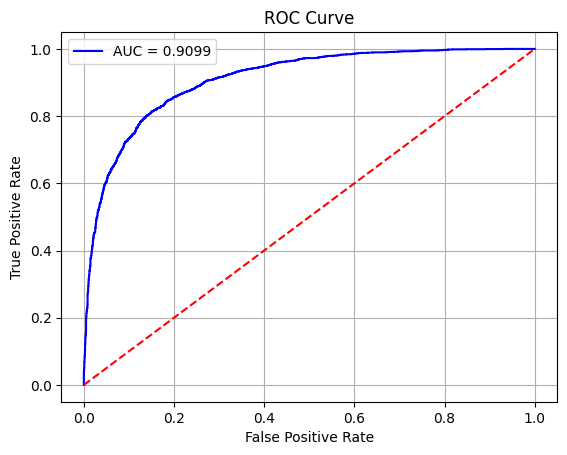

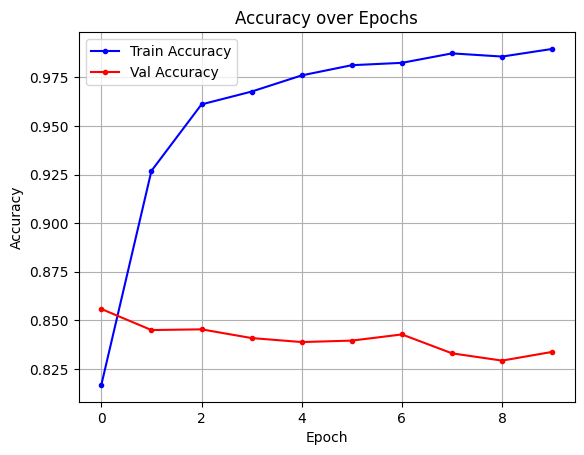

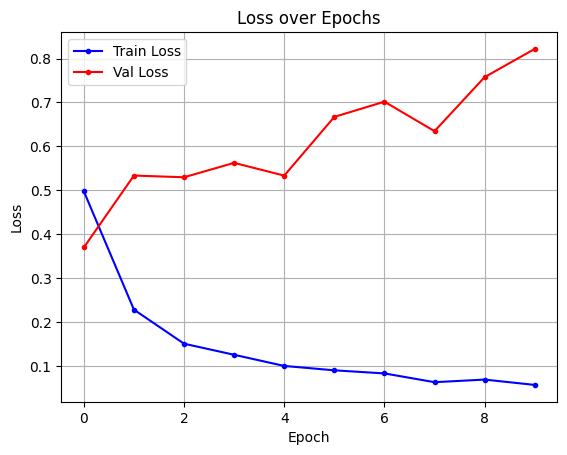

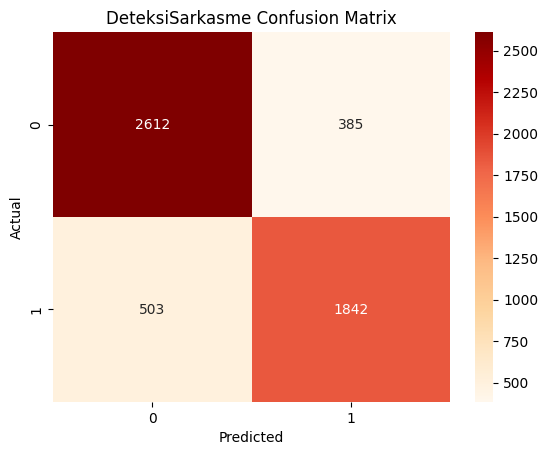

In [13]:
# Execution
def run(dataset_name, prepare_data_fn, max_features, max_length):

    x_train, y_train, x_test, y_test = prepare_data_fn()

    tuner = Hyperband(
        lambda hp: build_model(hp, max_features, max_length),
        objective='val_accuracy',
        max_epochs=EPOCHS_TUNER,
        factor=3,
        overwrite=True
    )

    print(f"\nTuning model for {dataset_name}...")
    tuner.search(
        x_train, y_train,
        epochs=EPOCHS_TUNER,
        batch_size=BATCH_SIZE,
        validation_split=validation_split
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("\nBest Hyperparameters:")
    for param, value in best_hps.values.items():
        print(f"{param}: {value}")

    best_model = tuner.hypermodel.build(best_hps)

    results = evaluate_and_visualize(
        best_model, x_train, y_train, x_test, y_test,
        dataset_name
    )

    return best_model, results

#Running
results = {}
model, res = run("DeteksiSarkasme", DeteksiSarkasme_dataset, MAX_FEATURES, MAX_LENGTH)
results["DeteksiSarkasme"] = res